# Esimate paramater for Normal distribution


In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## preparing observation data


In [12]:
SAMPLE_SIZE = 100_000
MEAN = 10
SCALE = 3

# N(10, 9)
population = np.random.normal(MEAN, SCALE, SAMPLE_SIZE)
observation = population[np.random.randint(0, SAMPLE_SIZE, 1000)]
observation

array([14.49172187,  9.10471739,  4.61960392, 11.41675861, 13.45116572,
       16.59921128, 14.940052  , 14.06590715,  9.78343705, 11.56102217,
        8.02622477,  8.96884665,  7.3478294 ,  7.83137707,  7.59255145,
        6.37335079,  9.99384792, 15.08039059, 14.50350834, 10.89531817,
       11.68857944,  9.25952365,  7.25967656, 10.69044398, 10.59934356,
       19.01069418,  9.01380729, 10.92645786, 13.95640796, 11.37181723,
       11.50656442, 11.6186474 ,  7.43804489,  7.83010471,  4.1268095 ,
       11.24477203, 13.04330339,  8.595061  ,  8.10487053, 10.09115771,
        9.97951955, 11.20716915, 11.03460079, 11.29029462,  6.48453226,
       10.59823167,  7.45164684, 12.06855964,  1.10003489,  9.47212274,
       14.64836363,  9.80390221,  9.0999715 , 21.14568965, 13.05897258,
        9.09561199, 10.09714335, 13.47573603,  6.93284645,  8.17609664,
        5.48096225,  6.64173206,  4.61626676,  7.47974152, 12.60954313,
        7.60917094, 10.97620819, 10.37511423, 11.06277574,  7.70

In [47]:
burn_in = int(0.25 * SAMPLE_SIZE)
burn_in

25000

Text(0.5, 0, 'data')

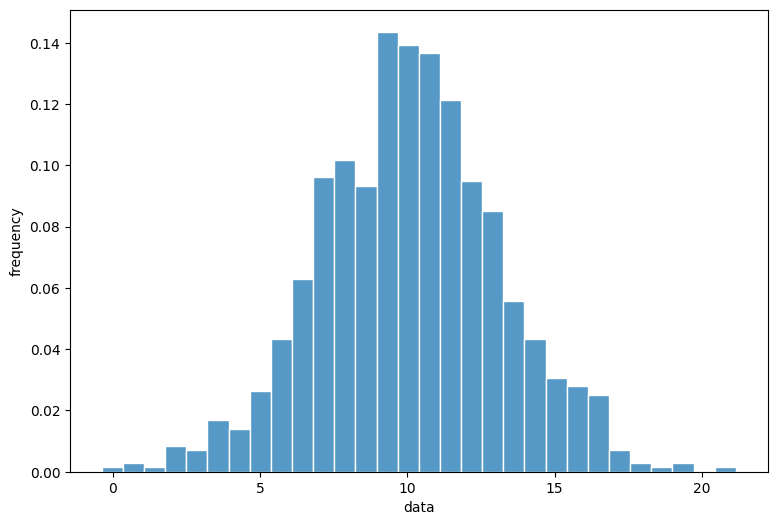

In [13]:
plt.figure(figsize=(9, 6))
sns.histplot(observation, stat="density", bins=30, edgecolor="w")
plt.ylabel("frequency")
plt.xlabel("data")

In [14]:
print(f"Mean of observation data: {observation.mean()}")
print(f"std of observation data: {np.sqrt(observation.var())}")

Mean of observation data: 10.078059980570611
std of observation data: 3.052916416365845


**NOTE:** Now we have to estimate the distribution. it looks like a normal distribution we have to find the parameter $\mu$ and $\sigma^2$


# Gibbs sampling


In [118]:
### Variables

## prior
# mu ~ N(mu0, sigma02)
mu0 = 10
sigma02 = 5

# sigm2 ~ INV-GAMMA(alpha, beta)
alpha = 2
beta = 5

# sigm2 ~ Scaled-INV-CHISQURE(v, sigma02) # degrees of fredom v -> 3 or 4 ( > 2) good choice
v = 4

### using inv gamma


In [119]:
sample = [
    [np.random.normal(mu0, np.sqrt(sigma02))],
    [1 / np.random.gamma(alpha, 1 / beta)],
]
for _ in range(SAMPLE_SIZE):
    current_sigma = sample[1][-1]
    mu_post_mean = (1 / ((1 / sigma02) + (len(observation) / current_sigma))) * (
        (mu0 / sigma02) + (observation.sum() / current_sigma)
    )
    mu_post_scale = (sigma02 * current_sigma) / (
        len(observation) * sigma02 + current_sigma
    )
    new_mu = np.random.normal(mu_post_mean, mu_post_scale)
    sigma_post_alpha = alpha + len(observation) / 2
    sigma_post_beta = beta + np.sum((observation - new_mu) ** 2) / 2
    new_sigma = 1 / np.random.gamma(sigma_post_alpha, 1 / sigma_post_beta)
    sample[0].append(new_mu)
    sample[1].append(new_sigma)

sample = np.array(sample)
sample

array([[13.75585073, 10.08415328, 10.06493079, ..., 10.09821043,
        10.0918423 , 10.07687047],
       [ 7.12601263,  9.24013017,  8.9932629 , ..., 10.21897867,
         8.57923537,  9.69636887]])

In [120]:
sample[0][burn_in:].mean()

10.077893488296475

In [121]:
sample[1][burn_in:].mean()

9.311703037659523

Text(0.5, 0, '$\\sigma^2$')

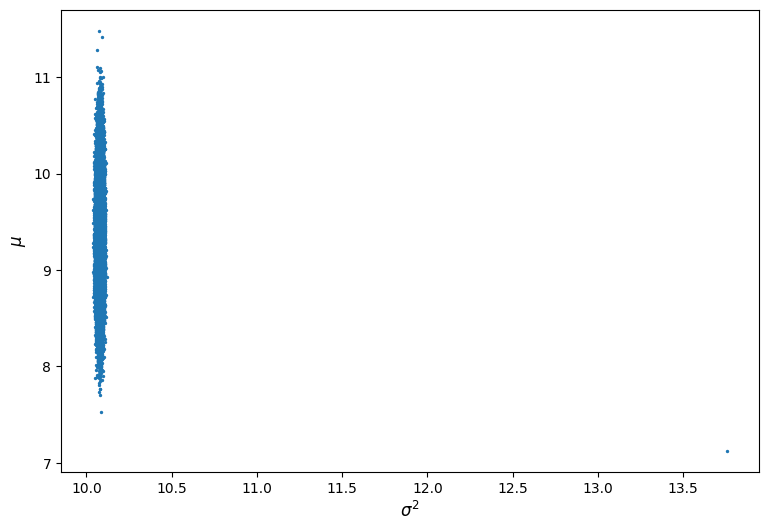

In [122]:
plt.figure(figsize=(9, 6))
plt.scatter(sample[0], sample[1], s=2)
plt.ylabel(r"$\mu$", fontsize=12)
plt.xlabel(r"$\sigma^2$", fontsize=12)

Text(0.5, 0, '$\\sigma^2$')

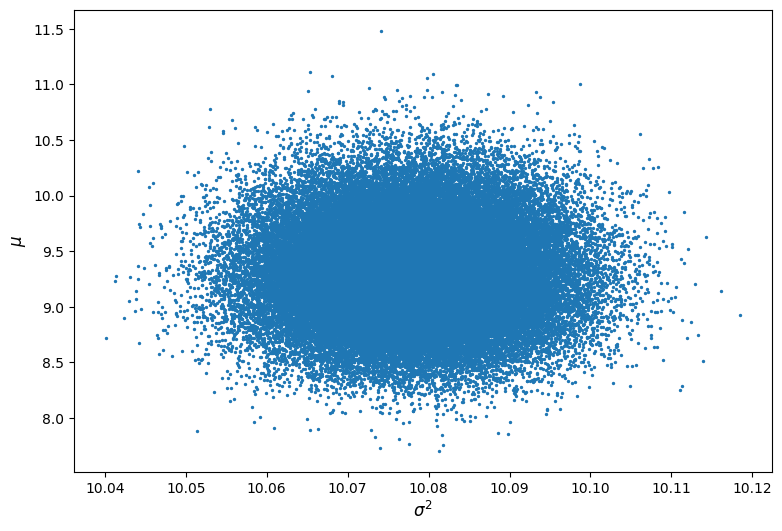

In [123]:
plt.figure(figsize=(9, 6))
plt.scatter(sample[0][burn_in:], sample[1][burn_in:], s=2)
plt.ylabel(r"$\mu$", fontsize=12)
plt.xlabel(r"$\sigma^2$", fontsize=12)

Text(0.5, 0, '$\\sigma^2$')

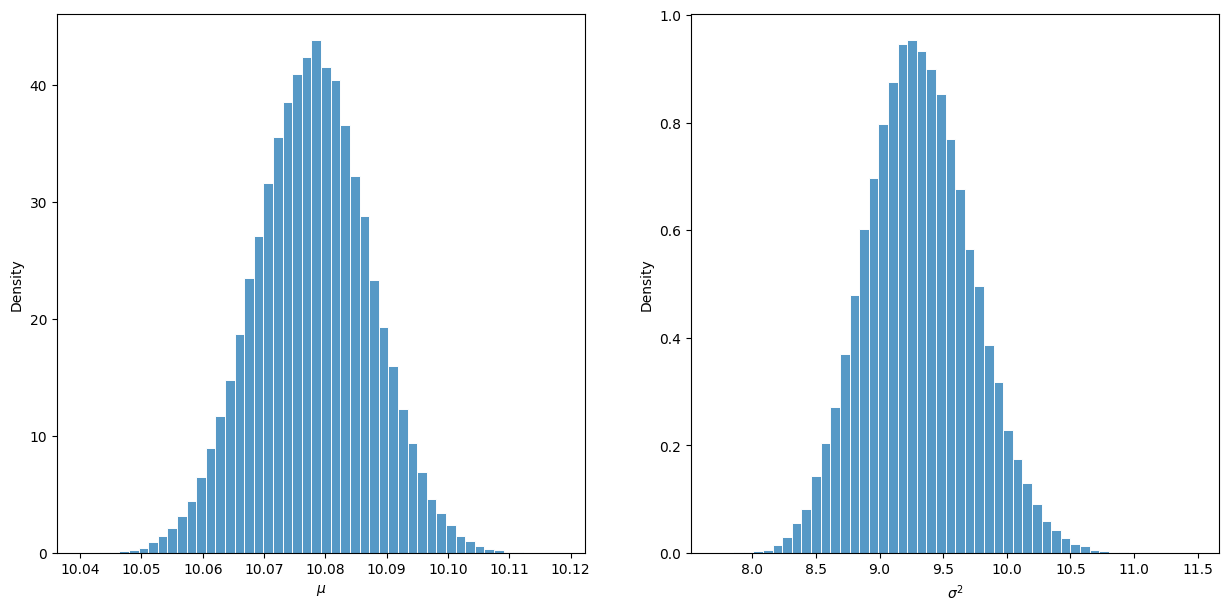

In [124]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
sns.histplot(sample[0][burn_in:], bins=50, edgecolor="w", stat="density")
plt.xlabel(r"$\mu$")

plt.subplot(122)
sns.histplot(sample[1][burn_in:], bins=50, edgecolor="w", stat="density")
plt.xlabel(r"$\sigma^2$")

## using Scaled inverse chisqure


In [125]:
sample2 = [
    [np.random.normal(mu0, np.sqrt(sigma02))],
    [sigma02 * v / np.random.chisquare(v)],
]
for _ in range(SAMPLE_SIZE):
    current_sigma = sample2[1][-1]
    mu_post_mean = (1 / ((1 / sigma02) + (len(observation) / current_sigma))) * (
        (mu0 / sigma02) + (observation.sum() / current_sigma)
    )
    mu_post_scale = (sigma02 * current_sigma) / (
        len(observation) * sigma02 + current_sigma
    )
    new_mu = np.random.normal(mu_post_mean, mu_post_scale)
    sigma_post_df = v + len(observation)
    sigma_post_scale = (
        v * sigma02 + np.sum((observation - new_mu) ** 2)
    ) / sigma_post_df
    new_sigma = sigma_post_scale * sigma_post_df / np.random.chisquare(sigma_post_df)
    sample2[0].append(new_mu)
    sample2[1].append(new_sigma)

sample2 = np.array(sample2)
sample2

array([[10.02732754, 10.07555187, 10.06598676, ..., 10.04902345,
        10.07849837, 10.07351601],
       [ 7.90792567,  9.47274532, 10.63540225, ...,  9.31132794,
         9.18182617, 10.17469702]])

In [126]:
sample2[0].mean()

10.077940153883672

In [127]:
sample2[1].mean()

9.320866518324824

Text(0.5, 0, '$\\sigma^2$')

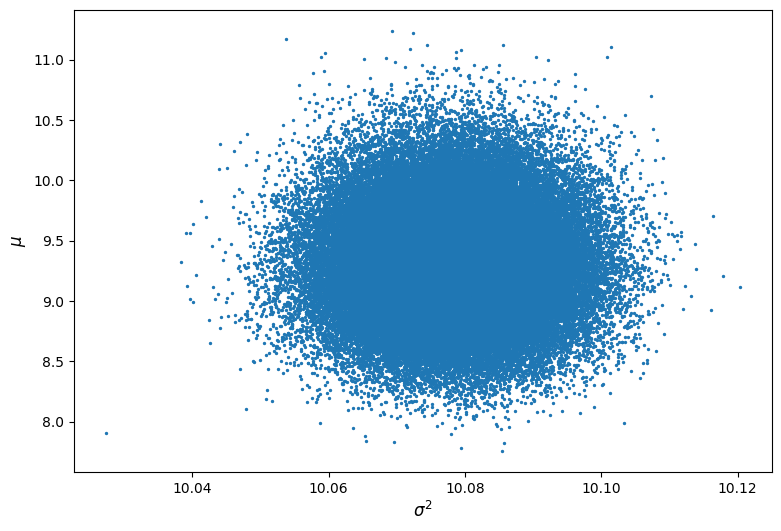

In [128]:
plt.figure(figsize=(9, 6))
plt.scatter(sample2[0], sample2[1], s=2)
plt.ylabel(r"$\mu$", fontsize=12)
plt.xlabel(r"$\sigma^2$", fontsize=12)

Text(0.5, 0, '$\\sigma^2$')

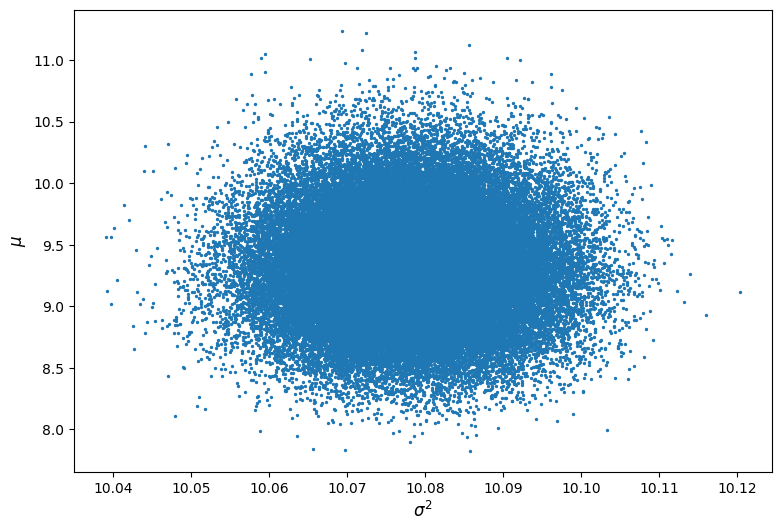

In [129]:
plt.figure(figsize=(9, 6))
plt.scatter(sample2[0][burn_in:], sample2[1][burn_in:], s=2)
plt.ylabel(r"$\mu$", fontsize=12)
plt.xlabel(r"$\sigma^2$", fontsize=12)

Text(0.5, 0, '$\\sigma^2$')

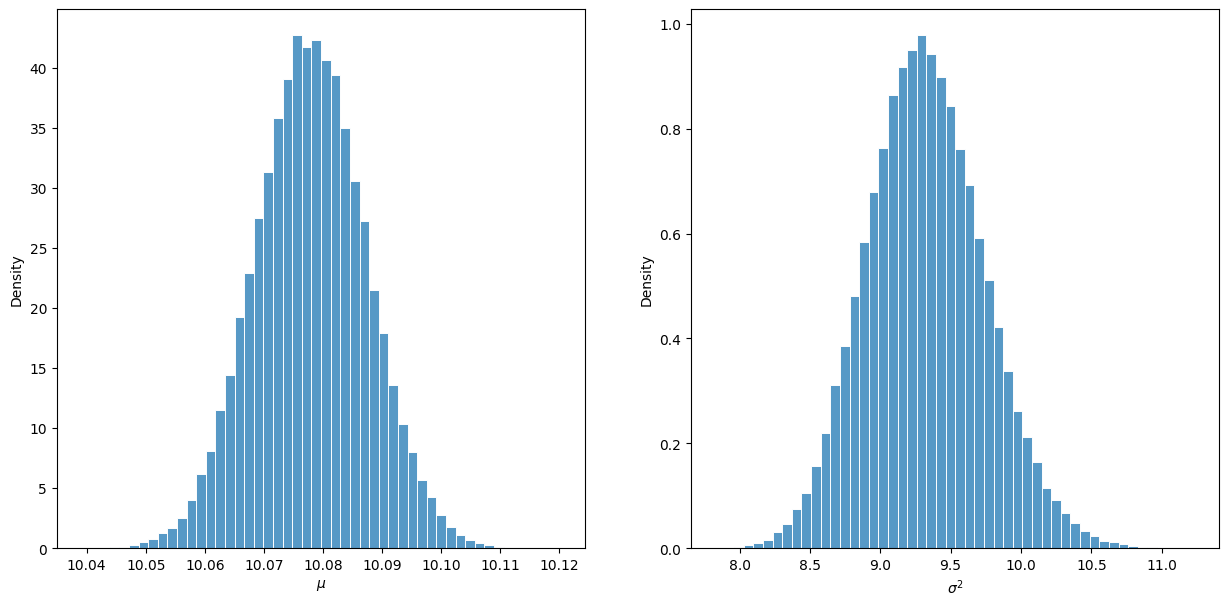

In [130]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
sns.histplot(sample2[0][burn_in:], bins=50, edgecolor="w", stat="density")
plt.xlabel(r"$\mu$")

plt.subplot(122)
sns.histplot(sample2[1][burn_in:], bins=50, edgecolor="w", stat="density")
plt.xlabel(r"$\sigma^2$")

## Comparism


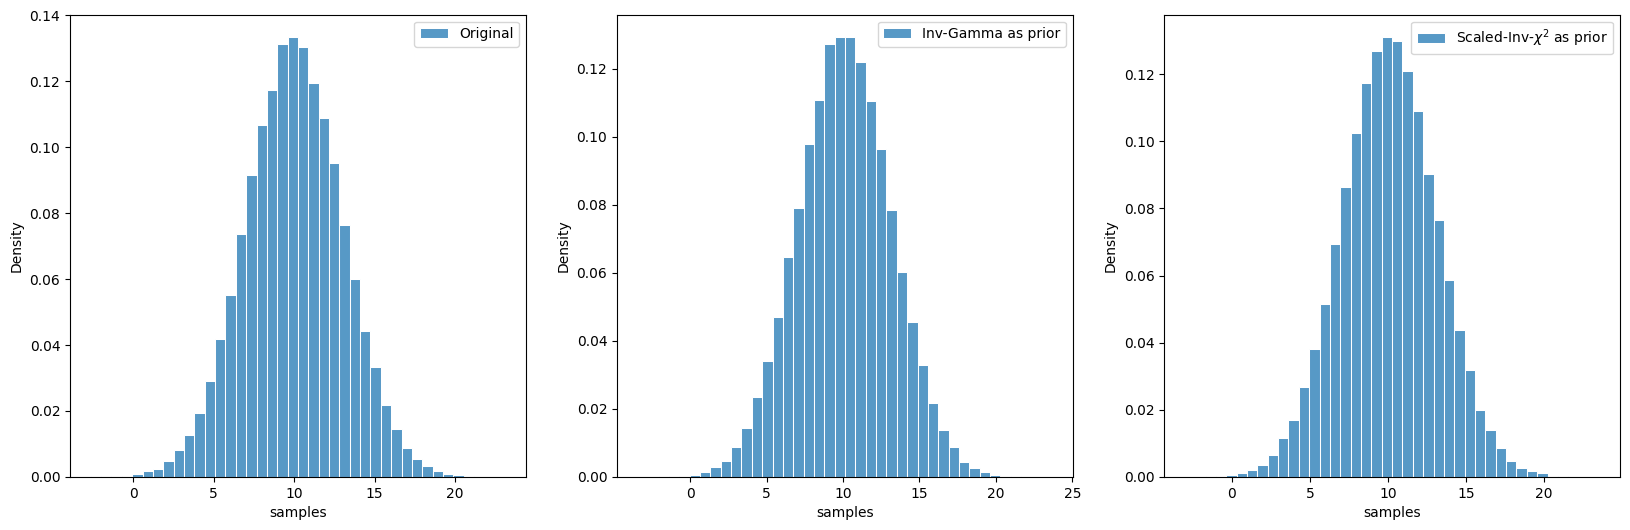

In [131]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.histplot(
    population,
    bins=40,
    edgecolor="w",
    label="Original",
    stat="density",
)
plt.xlabel("samples")
plt.legend()
plt.subplot(1, 3, 2)
sns.histplot(
    np.random.normal(sample[0].mean(), np.sqrt(sample[1].mean()), SAMPLE_SIZE),
    bins=40,
    edgecolor="w",
    label=r"Inv-Gamma as prior",
    stat="density",
)
plt.xlabel("samples")
plt.legend()
plt.subplot(1, 3, 3)
sns.histplot(
    np.random.normal(sample2[0].mean(), np.sqrt(sample2[1].mean()), SAMPLE_SIZE),
    edgecolor="w",
    bins=40,
    label=r"Scaled-Inv-$\chi^2$ as prior",
    stat="density",
)
plt.xlabel("samples")
plt.legend()